# FAKE NEWS CLASSIFICATIONS

In this project, I build a text classification to define whether or not a certain article is fake news or real. Using Natural Language Processing methodologies in Python and Classification Theory, I reached an accuracy of 0.94 for classifying news as fake or real.

In [56]:
## all imports and functions used in this notebook are writed in this python file
%run imports_functions.py
%matplotlib inline 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sak\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<Figure size 640x480 with 0 Axes>

### Clean & Save Data

Inspecting the data files, we noticed several issues for processing the traning dataset correctly. Using Regular Expression, we convert all commas between quotations to a pipe, so the CSV parsing works correctly with all values in their correct columns.

In [2]:
input_str = open("fake_or_real_news_training.csv", encoding= 'utf-8')

# Remove all new lines
noNewLines = re.sub("\n", "", input_str.read())

# re-add new line at end of each row
noNewLines = re.sub("X1,X2", "X1,X2\n", noNewLines)

noNewLines = re.sub(",FAKE[,]+", ",FAKE,,\n", noNewLines)
  
noNewLines = re.sub(",REAL[,]+", ",REAL,,\n", noNewLines)

# Replace any commas between two quotes with |
lines = noNewLines.split('\n')

def removeComma(g):
      t = g.groups()
      t = [t[0], t[1].replace(',', ' |'), t[2], t[3]]
      return "".join(t)

betweenQuotes = lambda line: re.sub(r'(.*,")(.*)(",)(.*)', lambda x: removeComma(x), line)

secondCol = lambda line: re.sub(r'^([0-9]+,)(.*,.*)(,\")(.*)$', lambda x: removeComma(x), line, 1)


lines = [betweenQuotes(l) for l in lines]
lines = [secondCol(l) for l in lines]

finalString = '\n'.join(lines)

### Save cleaned file

In [3]:
file = open('fake_or_real_news_training_CLEANED.csv', 'w',encoding= 'utf-8')
file.write(finalString)
file.close()

### Data Preparation

In [4]:
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")
test = pd.read_csv("fake_or_real_news_test.csv")

In [5]:
len(train)

3997

In [6]:
len(test)

2321

In [7]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,NaN,NaN


In [8]:
train = train.drop(['X1', 'X2'], axis=1)

In [11]:
test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [12]:
test['label'] = None  # empty label for test

In [14]:
df = pd.concat([train, test])

In [16]:
df

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL
...,...,...,...,...
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None


### Data Preprocessing

In this part we will be cleaning the articles with the help of different NLP techniques, of which we will first explain the concept and its importance.

In order to take into account the title in our accuracy prediction, we created an extra column that combines text and title. We will not do separate predictions on the title since these might classify as e.g. Fake news, whether the actual text with more explanation tells a Real story.

In [19]:
df['title_and_text'] = df['title'] +' '+ df['text']

In [21]:
df

,ID,title,text,label,title_and_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...
...,...,...,...,...,...
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se..."


preprocess() can be found in imports_functions.py

1. lowercase the text

2. remove the words counting just one letter

3. remove the words that contain numbers

4. tokenize the text and remove punctuation : we performed tokenization with the base python .string function, to split sentences into words (tokens). 

5. remove all stop words

6. remove tokens that are empty

7. pos tag the text : we use the pos_tag function included in the ntlk library. This classifies our tokenized words as a noun, verb, adjective or adverb and adds to the understaning of the articles.

8. lemmatize the text : in order to normalize the text, we apply lemmatization. In this way, words with the same root are processed equally.

In [28]:
df['preprocessed_text'] = df['title_and_text'].apply(lambda x: preprocess(x))

In [29]:
df

,ID,title,text,label,title_and_text,preprocessed_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...
...,...,...,...,...,...,...
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...


In [30]:
## Save preprocessed df
df.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

In [31]:
df = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")

In [32]:
df = df.astype(object).replace(np.nan, 'None')

In [34]:
df

,ID,title,text,label,title_and_text,preprocessed_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...
...,...,...,...,...,...,...
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...


### Split Train and Test again after pre-processing is done

In [35]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df)


Train dataset (Full)
(3997, 7)
Train dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text', 'encoded_label']

Train CV dataset (subset)
(2677, 7)
Train Holdout dataset (subset)
(1320, 7)

Test dataset
(2321, 6)
Test dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text']


In [36]:
encoder

LabelEncoder()

## Modelling

First, we create a dataframe called models to keep track of different models and their scores.

In [49]:
models = pd.DataFrame(columns=['model_name', 'model_object', 'score'])

### Vectorizing dataset

In [39]:
count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.preprocessed_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.preprocessed_text)
test_vector = count_vectorizer.transform(test.preprocessed_text)

### Model 1: SVC

Model 1: SVC
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.909 (+/-0.022) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.902 (+/-0.030) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.893 (+/-0.030) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.892 (+/-0.036) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.886 (+/-0.011) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=100, gamma=0.0001)


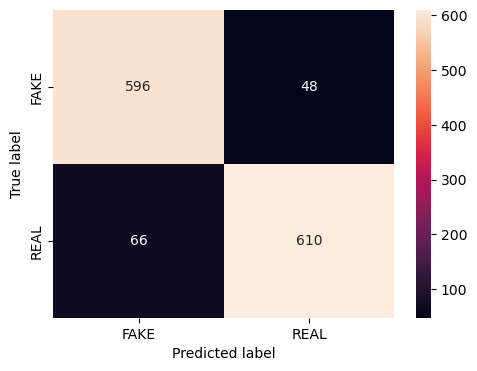


Accuracy:
0.9136363636363637


In [50]:
SVC = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "Model 1: SVC")
models.loc[len(models)] = SVC

### Model 2: Naïve Bayes

Model 2: Naiive Bayes
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.887 (+/-0.021) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


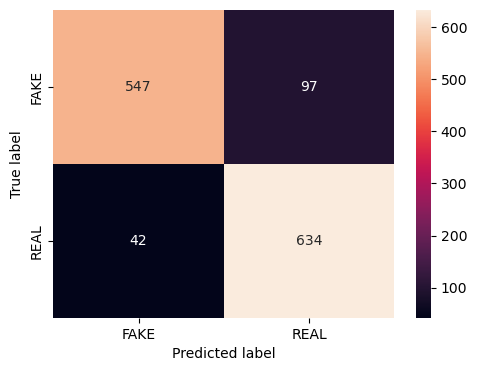


Accuracy:
0.8946969696969697


In [51]:
NB = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Model 2: Naiive Bayes")
models.loc[len(models)] = NB

### Model 3: MaxEnt Classifier

Model 3: MaxEnt Classifier
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.877 (+/-0.023) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.913 (+/-0.011) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.929 (+/-0.012) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.926 (+/-0.019) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.916 (+/-0.025) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100, 'penalty

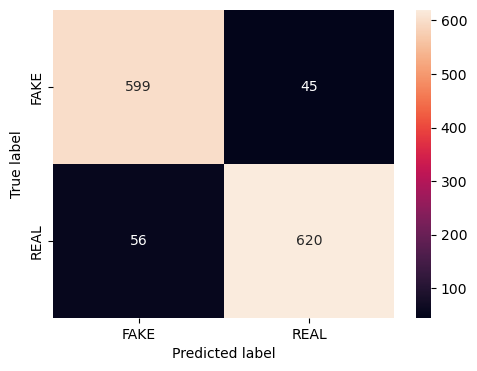


Accuracy:
0.9234848484848485


In [52]:
maxEnt = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "Model 3: MaxEnt Classifier")
models.loc[len(models)] = maxEnt

### Models Summary

In [53]:
models

,model_name,model_object,score
0,Model 1: SVC,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.913636
1,Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485


### Features

- Explicit POS tagging
- TF-IDF weighting
- Bigram Count Vectorizer

==> Select Final Model and predict on test

#### 1. POS Tagging

Adding a prefix to each word with its type (Noun, Verb, Adjective,...).
e.g: I went to school => PRP-I VBD-went TO-to NN-school

Also, after lemmatization it will be 'VB-go NN-school', which indicates the semantics and distinguishes the purpose of the sentence.

This will help the classifier differentiate between different types of sentences.

In [57]:
df['pos_tagged_text'] = df['preprocessed_text'].apply(lambda x: pos_tag_words(x))

In [58]:
df

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...
...,...,...,...,...,...,...,...
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...,NN-state NN-department VBP-say MD-ca RB-n't VB...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...,JJ-‘ NN-p NNP-’ NN-pb NN-stand NNP-‘ JJ-plutoc...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...,JJ-anti-trump NN-protester NN-tool JJ-oligarch...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...,JJ-ethiopia NN-obama JJ-seek NN-progress NN-pe...


### Run Models on pos-tagged text

In [59]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.pos_tagged_text)
test_vector = count_vectorizer.transform(test.pos_tagged_text)

### SVC with pos-tagged text

SVC on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.921 (+/-0.025) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.914 (+/-0.020) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.912 (+/-0.028) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.912 (+/-0.022) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.904 (+/-0.020) for params: {'C': 100, 'kernel': 'linear'}


Best Estimator Params
SVC(C=100, gamm

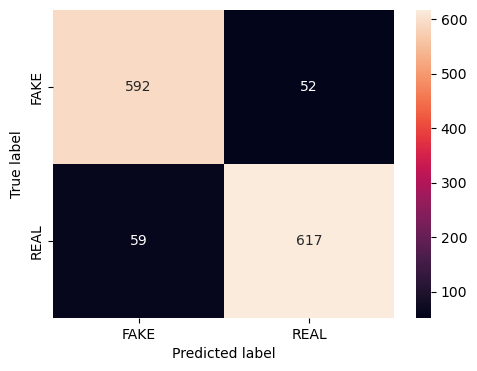


Accuracy:
0.9159090909090909


In [60]:
SVC_pos_tag = runModel(encoder,
               train_cv_vector,
               train_cv_label,
               train_holdout_vector,
               train_holdout.label,
               "svc",
               "SVC on pos-tagged text")
models.loc[len(models)] = SVC_pos_tag

### Naïve Bayes with pos-tagged text

Naiive Bayes on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.889 (+/-0.017) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


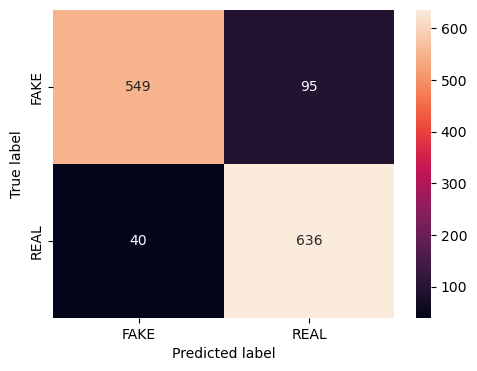


Accuracy:
0.8977272727272727


In [61]:
NB_pos_tag = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "nb",
              "Naiive Bayes on pos-tagged text")
models.loc[len(models)] = NB_pos_tag

### MaxEnt with pos-tagged text

MaxEnt Classifier on pos-tagged text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.885 (+/-0.013) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.918 (+/-0.017) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.929 (+/-0.029) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.930 (+/-0.027) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.930 (+/-0.028) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100

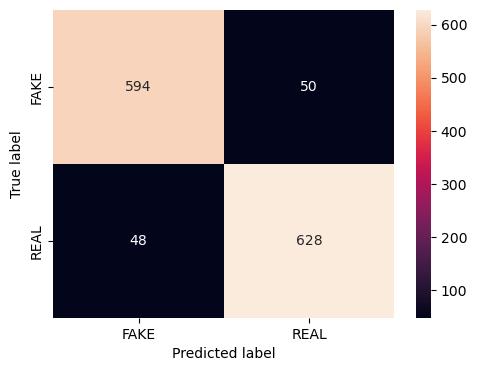


Accuracy:
0.9257575757575758


In [62]:
maxEnt_pos_tag = runModel(encoder,
              train_cv_vector,
              train_cv_label,
              train_holdout_vector,
              train_holdout.label,
              "maxEnt",
              "MaxEnt Classifier on pos-tagged text")
models.loc[len(models)] = maxEnt_pos_tag

In [63]:
models

,model_name,model_object,score
0,Model 1: SVC,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.913636
1,Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925758


<h4 style="color:blue">
There seems to be a slight increase of Accuracy after pos-tagging.
</h4>

#### 2. TF-IDF weighting

Try to add weight to each word using TF-IDF
<img src="https://cdn-images-1.medium.com/max/800/1*_OsV8gO2cjy9qcFhrtCdiw.jpeg" width="350px"/>

We are going to calculate the TFIDF score of each term in a piece of text. The text will be tokenized into sentences and each sentence is then considered a text item.

We will also apply those on the cleaned text and the concatinated POS_tagged text.

In [64]:
df["clean_and_pos_tagged_text"] = df['preprocessed_text'] + ' ' + df['pos_tagged_text']

In [65]:
df

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...,battle new york primary matter primary day new...
...,...,...,...,...,...,...,...,...
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...,NN-state NN-department VBP-say MD-ca RB-n't VB...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...,JJ-‘ NN-p NNP-’ NN-pb NN-stand NNP-‘ JJ-plutoc...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...,JJ-anti-trump NN-protester NN-tool JJ-oligarch...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...,JJ-ethiopia NN-obama JJ-seek NN-progress NN-pe...,ethiopia obama seek progress peace security ea...


In [66]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = "word")

count_vectorizer = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = count_vectorizer.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = count_vectorizer.transform(test.clean_and_pos_tagged_text)


tf_idf = TfidfTransformer(norm="l2")
train_cv_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_tf_idf = tf_idf.fit_transform(test_vector)  

### Run Models on pos-tagged + TF-IDF weighted text

### SVC with pos-tagged text + TF-IDF weighted text

SVC on pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params

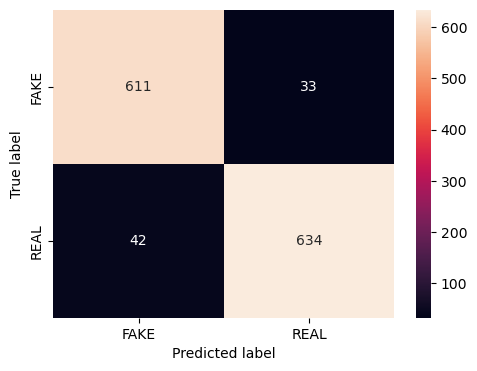


Accuracy:
0.9431818181818182


In [67]:
SVC_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on pos-tagged TF-IDF weighted text")
models.loc[len(models)] = SVC_tf_idf

### Naïve Bayes with pos-tagged text + TF-IDF weighted text

Naiive Bayes on pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=MultinomialNB(), param_grid={})

CV-scores
Accuracy: 0.781 (+/-0.039) for params: {}


Best Estimator Params
MultinomialNB()

Predictions:
['REAL' 'REAL' 'REAL' ... 'REAL' 'REAL' 'REAL']


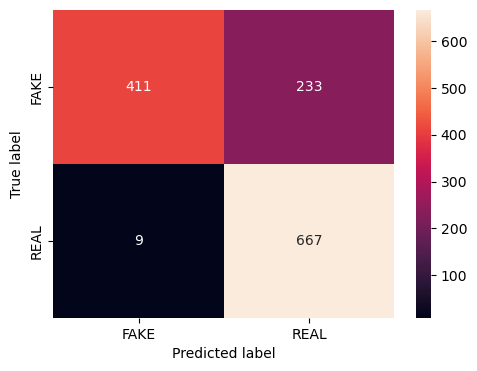


Accuracy:
0.8166666666666667


In [68]:
NB_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "nb",
              "Naiive Bayes on pos-tagged TF-IDF weighted text")
models.loc[len(models)] = NB_tf_idf

### MaxEnt with pos-tagged text + TF-IDF weighted text

MaxEnt on pos-tagged TF-IDF weighted text
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.554 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.004) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.022) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C'

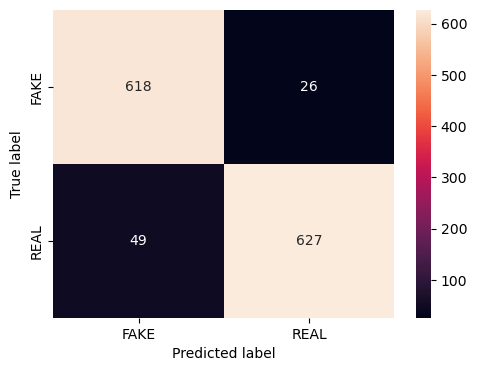


Accuracy:
0.9431818181818182


In [69]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_tf_idf,
               train_cv_label,
               train_holdout_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on pos-tagged TF-IDF weighted text")
models.loc[len(models)] = maxEnt_tf_idf

In [70]:
models

,model_name,model_object,score
0,Model 1: SVC,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.913636
1,Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925758
6,SVC on pos-tagged TF-IDF weighted text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
7,Naiive Bayes on pos-tagged TF-IDF weighted text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.816667
8,MaxEnt on pos-tagged TF-IDF weighted text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182


<h4 style="color:blue">
Using TF-IDF increased the score to ~94% with SVC and Max-Ent models.
<br><br>
Naive-Bayes rather decreased the score. Therefore we drop it from the pipeline.
</h4>

### 3. Use Bigram Vectorizer instead of regular vectorizer

Now we will use the Trigram vectorizer, which vectorizes **triplets of words** rather than each word separately. *In this short example sentence*, the trigrams are "In this short", "this short example" and "short example sentence".

In [71]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,2))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = trigram_vect.transform(test.clean_and_pos_tagged_text)

In [72]:
tf_idf = TfidfTransformer(norm="l2")
train_cv_bigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_bigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_bigram_tf_idf = tf_idf.fit_transform(test_vector)

### Run Models on pos-tagged + TF-IDF weighted + Trigram Vectorized text

### SVC on pos-tagged + TF-IDF weighted + Trigram Vectorized text

SVC on bigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 50, 100], 'kernel': ['linear']},
                         {'C': [10, 100, 500, 1000], 'gamma': [0.0001],
                          'kernel': ['rbf']}])

CV-scores
Accuracy: 0.937 (+/-0.024) for params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 50, 'kernel': 'linear'}
Accuracy: 0.937 (+/-0.027) for params: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.935 (+/-0.021) for params: {'C': 1, 'kernel': 'linear'}
Accuracy: 0.895 (+/-0.009) for params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.859 (+/-0.015) for params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.590 (+/-0.139) for params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.481 (+/-0.027) for params: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


Best Estimator Params
SVC(C=10, 

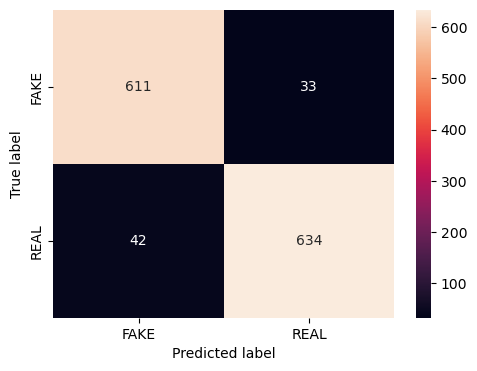


Accuracy:
0.9431818181818182


In [73]:
SVC_trigram_tf_idf = runModel(encoder,
               train_cv_bigram_tf_idf,
               train_cv_label,
               train_holdout_bigram_tf_idf,
               train_holdout.label,
               "svc",
               "SVC on bigram vect.+ TF-IDF")
models.loc[len(models)] = SVC_trigram_tf_idf

### MaxEnt on pos-tagged + TF-IDF weighted + Trigram Vectorized text

In [74]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = "word", ngram_range=(1,3))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)

In [76]:
tf_idf = TfidfTransformer(norm="l2")
train_cv_trigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_trigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)

MaxEnt on trigram vect.+ TF-IDF
GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.2, train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

CV-scores
Accuracy: nan (+/-nan) for params: {'C': 0.001, 'penalty': 'l1'}
Accuracy: 0.554 (+/-0.147) for params: {'C': 0.001, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.01, 'penalty': 'l1'}
Accuracy: 0.749 (+/-0.021) for params: {'C': 0.01, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.831 (+/-0.023) for params: {'C': 0.1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.907 (+/-0.004) for params: {'C': 1, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.931 (+/-0.022) for params: {'C': 10, 'penalty': 'l2'}
Accuracy: nan (+/-nan) for params: {'C': 100, 'pe

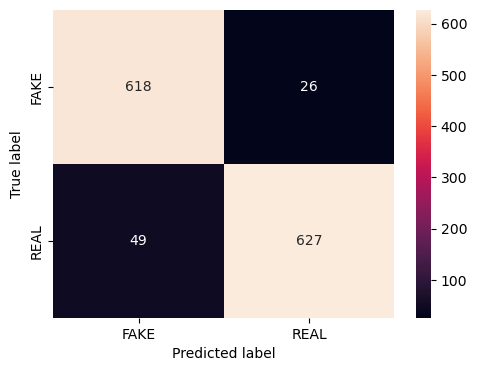


Accuracy:
0.9431818181818182


In [77]:
maxEnt_tf_idf = runModel(encoder,
               train_cv_trigram_tf_idf,
               train_cv_label,
               train_holdout_trigram_tf_idf,
               train_holdout.label,
              "maxEnt",
              "MaxEnt on trigram vect.+ TF-IDF")
models.loc[len(models)] = maxEnt_tf_idf

In [78]:
models

,model_name,model_object,score
0,Model 1: SVC,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.913636
1,Model 2: Naiive Bayes,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.894697
2,Model 3: MaxEnt Classifier,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.923485
3,SVC on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.915909
4,Naiive Bayes on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.897727
5,MaxEnt Classifier on pos-tagged text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.925758
6,SVC on pos-tagged TF-IDF weighted text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
7,Naiive Bayes on pos-tagged TF-IDF weighted text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.816667
8,MaxEnt on pos-tagged TF-IDF weighted text,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182
9,SVC on bigram vect.+ TF-IDF,"GridSearchCV(cv=ShuffleSplit(n_splits=5, rando...",0.943182


<h4 style="color:blue">
It looks like the "MaxEnt on trigram vect.+ TF-IDF" is the best model with the highest score. We will use it to predict and classify the testset.
</h4>

### Predicting on test dataset

### Train on whole data and predict on test

#### Preprocessing

In [79]:
test = pd.read_csv("fake_or_real_news_test.csv")
train = pd.read_csv("fake_or_real_news_training_CLEANED.csv")

In [80]:
train['title_and_text'] = train['title'] +' '+ train['text']
train['preprocessed_text'] = train['title_and_text'].apply(lambda x: preprocess(x))

In [81]:
test['title_and_text'] = test['title'] +' '+ test['text']
test['preprocessed_text'] = test['title_and_text'].apply(lambda x: preprocess(x))

In [82]:
train

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,NaN,NaN,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,NaN,NaN,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,NaN,NaN,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...
...,...,...,...,...,...,...,...,...
3992,802,"Fault lines: GOP civil war deepens |""Washingto...","Romney said. """"Entertainment media distracts ...",REAL,NaN,NaN,"Fault lines: GOP civil war deepens |""Washingto...",fault line gop civil war deepens washington cn...
3993,1026,Clinton | under fire for oil and gas donations...,"Fallon said. """"We have not accused Senator Sa...",REAL,NaN,NaN,Clinton | under fire for oil and gas donations...,clinton fire oil gas donation hit obama reason...
3994,1459,His rivals are saying the same thing in differ...,Chris Christie depicts Marco Rubio as a truant...,REAL,NaN,NaN,His rivals are saying the same thing in differ...,rival say thing different way marco rubio weak...
3995,5366,The Genocide of Indigenous Peoples in North Am...,Prof. Tony Hall Speaks Out on Mohawk Territory...,FAKE,NaN,NaN,The Genocide of Indigenous Peoples in North Am...,genocide indigenous people north america pales...


In [83]:
train.to_csv("fake_or_real_news_train_PREPROCESSED.csv", index=False)

In [84]:
test

,ID,title,text,title_and_text,preprocessed_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...
...,...,...,...,...,...
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,State Department says it can't find emails fro...,state department say can't find emails clinton...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...","In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...


In [85]:
test.to_csv("fake_or_real_news_test_PREPROCESSED.csv", index=False)

In [86]:
train = pd.read_csv("fake_or_real_news_train_PREPROCESSED.csv")
train = train.astype(object).replace(np.nan, 'None')

In [87]:
test = pd.read_csv("fake_or_real_news_test_PREPROCESSED.csv")
test = test.astype(object).replace(np.nan, 'None')

In [88]:
train.head()

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,None,None,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,None,None,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,None,None,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,None,None,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,None,None,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...


In [89]:
test.head()

,ID,title,text,title_and_text,preprocessed_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...


### POS Tagging

In [90]:
train['pos_tagged_text'] = train['preprocessed_text'].apply(lambda x: pos_tag_words(x))

In [91]:
test['pos_tagged_text'] = test['preprocessed_text'].apply(lambda x: pos_tag_words(x))

### Merge clean and pos tagged text

In [92]:
train["clean_and_pos_tagged_text"] = train['preprocessed_text'] + ' ' + train['pos_tagged_text']

In [94]:
train.head()

,ID,title,text,label,X1,X2,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,None,None,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,None,None,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...,watch exact moment paul ryan commit political ...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,None,None,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...,kerry go paris gesture sympathy u.s secretary ...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,None,None,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...,bernie supporter twitter erupt anger dnc try w...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,None,None,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...,battle new york primary matter primary day new...


In [93]:
test["clean_and_pos_tagged_text"] = test['preprocessed_text'] + ' ' + train['pos_tagged_text']

In [95]:
test.head()

,ID,title,text,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...,VB-september JJ-new NN-home NN-sale JJ-rise——-...,september new home sale rise——-back level sept...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...,NN-obamacare NN-doomsday NN-cult MD-ca RB-n't ...,obamacare doomsday cult can't admit wrong cong...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...,NN-sander NNS-cruz VBP-resist NN-pressure JJ-n...,sander cruz resist pressure ny loss vow fight ...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...,JJ-survive NN-escape NN-prisoner JJ-likely NN-...,survive escape prisoner likely fatigue prone m...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...,NN-clinton NN-sander NN-neck NN-neck NN-califo...,clinton sander neck neck california primary ma...


### Modelling using MaxEnt on trigram vect.+ TF-IDF Grid Search Best params

### Trigram + TfIDF + classifier pipeline

In [96]:
from sklearn.pipeline import Pipeline
trigram_vectorizer = CountVectorizer(analyzer = "word", ngram_range=(1,3))
tf_idf = TfidfTransformer(norm="l2")
classifier = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

pipeline = Pipeline([
     ('trigram_vectorizer', trigram_vectorizer),
     ('tfidf', tf_idf),
     ('clf', classifier),
 ])

In [97]:
pipeline.fit(train.clean_and_pos_tagged_text, encoder.fit_transform(train.label.values))

Pipeline(steps=[('trigram_vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1000, multi_class='multinomial',
                                    solver='saga'))])

In [98]:
import pickle
pickle.dump( pipeline, open( "pipeline.pkl", "wb" ) )

### Predicting on test

In [99]:
print(colored("Predicting on test", 'blue'))
test_predictions = test_predictions = pipeline.predict(test.clean_and_pos_tagged_text)

Predicting on test


In [100]:
test_predictions

array([0, 0, 1, ..., 1, 1, 1])

In [101]:
test_predictions_decoded = encoder.inverse_transform( test_predictions )

In [102]:
predictions = test
predictions["label"] = test_predictions_decoded

In [103]:
predictions.shape

(2321, 8)

In [104]:
predictions.head()

,ID,title,text,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text,label
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,September New Homes Sales Rise——-Back To 1992 ...,september new home sale rise——-back level sept...,VB-september JJ-new NN-home NN-sale JJ-rise——-...,september new home sale rise——-back level sept...,FAKE
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,Why The Obamacare Doomsday Cult Can't Admit It...,obamacare doomsday cult can't admit wrong cong...,NN-obamacare NN-doomsday NN-cult MD-ca RB-n't ...,obamacare doomsday cult can't admit wrong cong...,FAKE
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,"Sanders, Cruz resist pressure after NY losses,...",sander cruz resist pressure ny loss vow fight ...,NN-sander NNS-cruz VBP-resist NN-pressure JJ-n...,sander cruz resist pressure ny loss vow fight ...,REAL
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,Surviving escaped prisoner likely fatigued and...,survive escape prisoner likely fatigue prone m...,JJ-survive NN-escape NN-prisoner JJ-likely NN-...,survive escape prisoner likely fatigue prone m...,REAL
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,Clinton and Sanders neck and neck in Californi...,clinton sander neck neck california primary ma...,NN-clinton NN-sander NN-neck NN-neck NN-califo...,clinton sander neck neck california primary ma...,REAL


In [105]:
predictions.label.describe()

count     2321
unique       2
top       REAL
freq      1330
Name: label, dtype: object

In [107]:
predictions.drop(columns=["title","text","title_and_text","preprocessed_text","pos_tagged_text","clean_and_pos_tagged_text"]).head()

,ID,label
0,10498,FAKE
1,2439,FAKE
2,864,REAL
3,4128,REAL
4,662,REAL


In [108]:
predictions.to_csv("TEST_PREDICTIONS.csv", index=False)